In [3]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from DataRead import OurData
import traceback
import struct

from kan import KAN, create_dataset

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 28*28 # from 28*28

In [4]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, dtype, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        return torch.tensor(np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)).to(torch.float32)

class OurData:
    def __init__(self):
        self.ourdataset = {}
        train_images = read_idx('/workspaces/KAN-Network/Dataset/train-images-idx3-ubyte/train-images-idx3-ubyte') #contains the training data, each data is the binary representation of an image as per the MNIST dataset
        self.ourdataset['train_input'] = (train_images).view(-1, 28*28) #reshapes the data into a 2D array, each row is an image
        test_images = read_idx('/workspaces/KAN-Network/Dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte') #contains the testing data, same format as train_input
        self.ourdataset['test_input'] = (test_images).view(-1, 28*28) #reshapes the data into a 2D array, each row is an image
        self.ourdataset['train_label'] = read_idx('/workspaces/KAN-Network/Dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte').unsqueeze(1) #contains the labels for the training data
        self.ourdataset['test_label'] = read_idx('/workspaces/KAN-Network/Dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte').unsqueeze(1) #contains the labels for the testing data
        #print("These are our training inputs and labels")
    def __getitem__(self):
        return self.ourdataset
    def getitems(self, index, endindex = 10000, test = True):
        key = 'test_input' if test else 'train_input'
        key2 = 'test_label' if test else 'train_label'
        return [self.ourdataset[key][index:endindex], self.ourdataset[key2][index:endindex]]

In [5]:
def getsliced(dataset, slice = 1):
        fraction = int(784/slice)
        arr = torch.tensor([])
        for i in range(slice):
            arr = torch.cat((arr, dataset[:, i*fraction:(i+1)*fraction].sum(dim=1, keepdim=True)), dim=1)
        return arr

data = OurData() #Our dataset
ourdata = {}
ourdata2 = {}
ourdata3 = {}
for key in data.ourdataset:
    #total train datapoints=60000, test datapoints=10000. approx time:1min/100 points model1, 30s/1000 points model2, 1min/2500 points model3
    ourdata[key] = data.ourdataset[key][:200] #only get the first 200 data points for now
    ourdata2[key] = getsliced(data.ourdataset[key], 28)[:4000] #each element is a sum of a row of the 2d array
    ourdata3[key] = getsliced(data.ourdataset[key], 3)[:5000] #each element is a sum of a third of the entire 2d array

In [6]:
'''
initialize model
- refer to MultKAN.py for more information
    width: number of neurons in each layer, in order from input to output
    k: order of the spline
    seed: random seed
    grid: grid intervals/grid points (affects the accuracy of the splines/learnable functions)
'''
model = KAN(width=[784, 10, 1], grid=5, k=3, seed=0, device=device)
model2 = KAN(width=[28, 20, 1], grid=5, k=3, seed=0, device=device, ckpt_path='./model2')
model3 = KAN(width=[3, 25, 1], grid=5, k=3, seed=0, device=device, ckpt_path='./model3')

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model2
saving model version 0.0
checkpoint directory created: ./model3
saving model version 0.0


In [7]:
model(ourdata['train_input']) #forward pass of the model
model2(ourdata2['train_input']) 
model3(ourdata3['train_input']) 
#print("model pass complete")
#model.plot() #plots the model, avoid doing this since it will plot functions for all the neurons(and we have a lot since we are dealing with images)

#steps = intervals to divide the dataset and update model, epochs = how many times the entire dataset is passed through the model
modelresults = []
modelresults.append(model.fit(ourdata, opt="LBFGS", steps=50, lamb=0.001)) #values from the basic example in the documentation
modelresults.append(model2.fit(ourdata2, opt="LBFGS", steps=50, lamb=0.001))
modelresults.append(model3.fit(ourdata3, opt="LBFGS", steps=50, lamb=0.001))

| train_loss: 1.05e-01 | test_loss: 2.69e+00 | reg: 2.59e+01 | : 100%|█| 50/50 [02:01<00:00,  2.42s/


saving model version 0.1


| train_loss: 9.91e-01 | test_loss: 1.05e+00 | reg: 5.61e+01 | : 100%|█| 50/50 [02:13<00:00,  2.67s/


saving model version 0.1


| train_loss: 2.70e+00 | test_loss: 2.70e+00 | reg: 3.74e+01 | : 100%|█| 50/50 [02:01<00:00,  2.42s/

saving model version 0.1


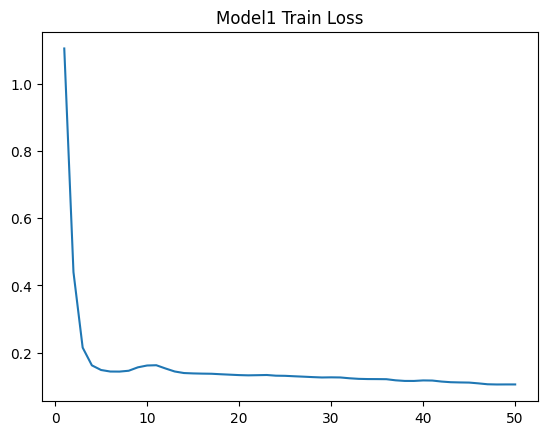

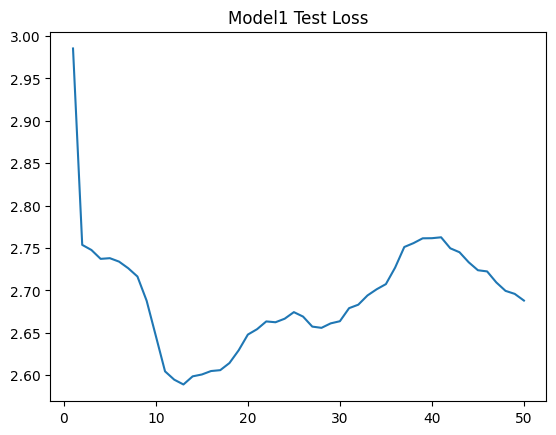

In [8]:
plt.plot(range(1, len(modelresults[0]['train_loss']) + 1), modelresults[0]['train_loss'])
plt.title('Model1 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[0]['test_loss']) + 1), modelresults[0]['test_loss'])
plt.title('Model1 Test Loss')
plt.show()

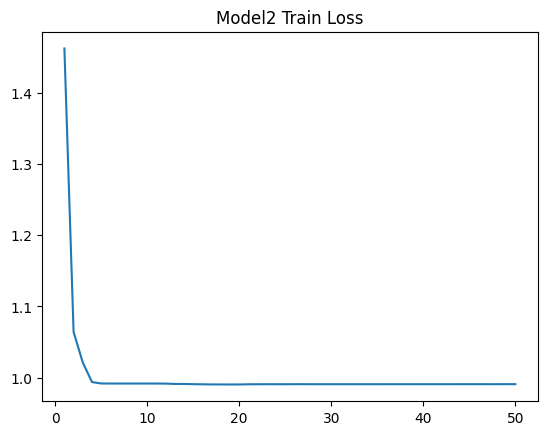

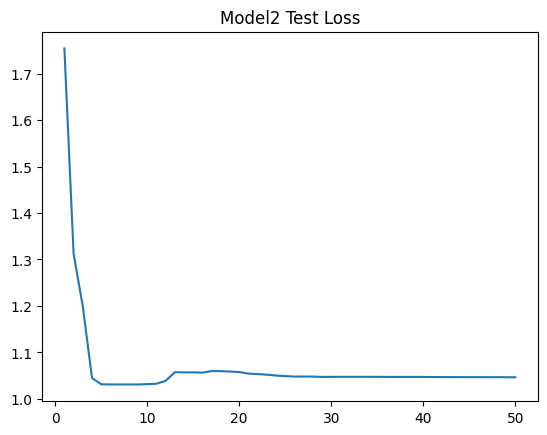

In [9]:
plt.plot(range(1, len(modelresults[1]['train_loss']) + 1), modelresults[1]['train_loss'])
plt.title('Model2 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[1]['test_loss']) + 1), modelresults[1]['test_loss'])
plt.title('Model2 Test Loss')
plt.show()

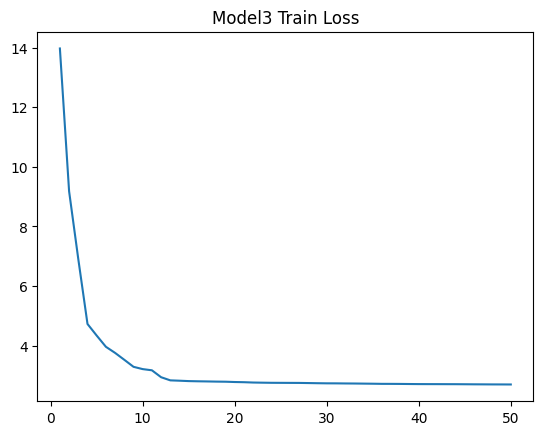

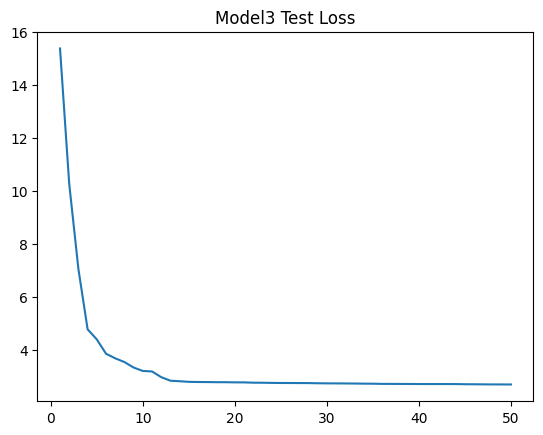

In [10]:
plt.plot(range(1, len(modelresults[2]['train_loss']) + 1), modelresults[2]['train_loss'])
plt.title('Model3 Train Loss')
plt.show()
plt.plot(range(1, len(modelresults[2]['test_loss']) + 1), modelresults[2]['test_loss'])
plt.title('Model3 Test Loss')
plt.show()

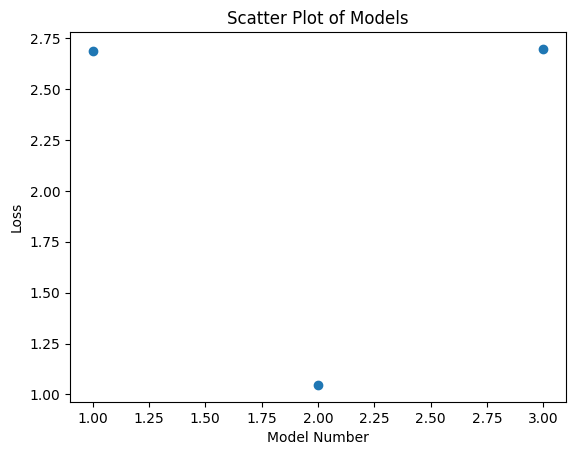

In [11]:
eval1 = model.evaluate(ourdata)
eval2 = model2.evaluate(ourdata2)
eval3 = model3.evaluate(ourdata3)
evaluation_results = [eval1, eval2, eval3]
test_losses = [[result['test_loss'] for result in evaluation_results]]

plt.scatter([i for i in range(1, 4)], test_losses, label='Test Loss')
plt.xlabel('Model Number')
plt.ylabel('Loss')
plt.title('Scatter Plot of Models')
plt.show()

In [12]:
testingdata = data.getitems(9950, 10000) 
predictions = model.forward(testingdata[0])
predictions2 = model2.forward(getsliced(testingdata[0], 28))
predictions3 = model3.forward(getsliced(testingdata[0], 3))
allpredictions = [predictions, predictions2, predictions3]

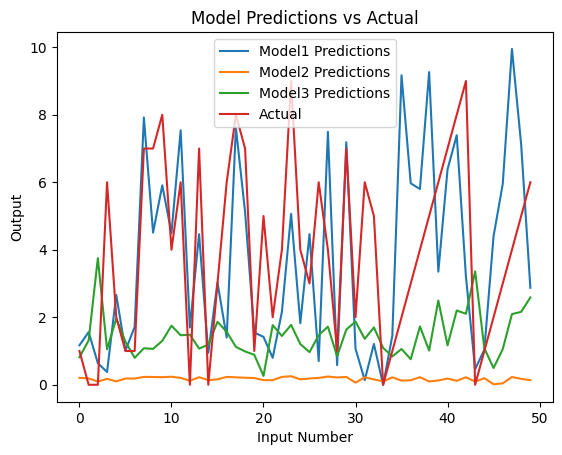

In [13]:
for i in range(3):
    plt.plot(range(len(allpredictions[i])), allpredictions[i].detach().numpy(), label=f'Model{i+1} Predictions')
plt.plot(range(len(testingdata[1])), testingdata[1].detach().numpy(), label='Actual')
plt.xlabel('Input Number')
plt.ylabel('Output')
plt.title('Model Predictions vs Actual')
plt.legend()
plt.show()

0 1.0	1 1.1702417135238647	2 0.2052488774061203	3 0.81512451171875	
1 0.0	1 1.560465693473816	2 0.18816380202770233	3 1.31390380859375	
2 0.0	1 0.6388042569160461	2 0.09498608112335205	3 3.751373291015625	
3 6.0	1 0.37849053740501404	2 0.17451857030391693	3 1.0508270263671875	
4 2.0	1 2.6612632274627686	2 0.09897442162036896	3 1.962493896484375	
5 1.0	1 1.0105561017990112	2 0.18517902493476868	3 1.2738037109375	
6 1.0	1 1.717216968536377	2 0.1833767592906952	3 0.7971343994140625	
7 7.0	1 7.920411586761475	2 0.23251216113567352	3 1.0819854736328125	
8 7.0	1 4.507618427276611	2 0.23016901314258575	3 1.0635986328125	
9 8.0	1 5.909841060638428	2 0.2230730950832367	3 1.3009490966796875	
10 4.0	1 4.4933390617370605	2 0.23861894011497498	3 1.7503128051757812	
11 6.0	1 7.540290355682373	2 0.20307548344135284	3 1.4664306640625	
12 0.0	1 1.698808193206787	2 0.11750202625989914	3 1.484710693359375	
13 7.0	1 4.460675239562988	2 0.2239404022693634	3 1.0711212158203125	
14 0.0	1 0.9427824020385742	2

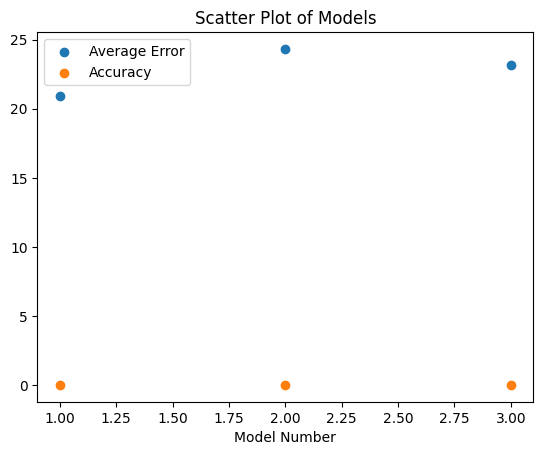

In [ ]:
error = [0, 0, 0]
correct = [0, 0, 0]
for i in range(len(testingdata[1])):
    print(i, testingdata[1][i].item(), end="\t")
    for j in range(3):
        print(j+1, allpredictions[j][i].item(), end="\t")
        difference = abs(allpredictions[j][i].item()-i)
        error[j] += difference
    print()
for j in range(3):
    error[j] /= len(testingdata[1])
    correct[j] = 100 - 100*(error[j] if error[j] < 1 else 1)

plt.scatter([i for i in range(1, 4)], error, label='Average Error') 
plt.scatter([i for i in range(1, 4)], correct, label='Accuracy') 
plt.xlabel('Model Number')
plt.title('Scatter Plot of Models')
plt.legend()
print(error)
print(correct)


In [ ]:
#a different method of calculating error, convert into a classification problem
#figure out how to save and load models
#experiment with parameters for better accuracy - grid, k, width/length, lamb, steps, lossfn, 